<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gaussian-Mixture-Model-Selection" data-toc-modified-id="Gaussian-Mixture-Model-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gaussian Mixture Model Selection</a></span></li></ul></div>

In [1]:
%matplotlib inline


# Gaussian Mixture Model Selection

Este exemplo mostra que a seleção do modelo pode ser realizada com
Modelos de Mistura Gaussianas usando `critérios teóricos da informação (BIC) <aic_bic>`.
A seleção do modelo diz respeito tanto ao tipo de covariância
e o número de componentes no modelo.
Nesse caso, o AIC também fornece o resultado correto (não mostrado para economizar tempo),
mas o BIC é mais adequado se o problema for identificar o modelo correto.
Ao contrário dos procedimentos Bayesianos, tais inferências são livres de a priori.

Nesse caso, o modelo com 2 componentes e covariância total
(que corresponde ao verdadeiro modelo generativo) é selecionado.


In [ ]:
import numpy as np
import itertools

from scipy              import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

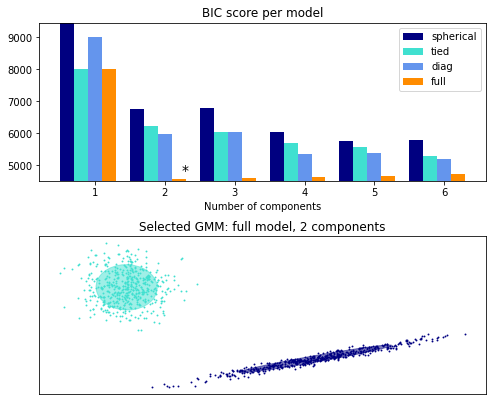

In [2]:


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
X = np.r_[
    np.dot(np.random.randn(n_samples, 2), C),
    0.7 * np.random.randn(n_samples, 2) + np.array([-6, 3]),
]

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()